---------------

**If any part of this notebook is used in your research, please cite with the reference found in** **[README.md](https://github.com/pysal/spaghetti#bibtex-citation).**


----------------

## Network point pattern attributes
### Demonstrating network point pattern representation

**Author: James D. Gaboardi** **<jgaboardi@gmail.com>**

**This notebook is an basic walk-through for:**

1. Exploring the attributes of network objects and point patterns
2. Generating observation counts per network link
3. Simulating a point pattern

In [1]:
%load_ext watermark
%watermark

2020-04-20T13:48:40-04:00

CPython 3.7.3
IPython 7.10.2

compiler   : Clang 9.0.0 (tags/RELEASE_900/final)
system     : Darwin
release    : 19.4.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [2]:
import geopandas
import libpysal
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import pandas
import shapely
from shapely.geometry import Point
import spaghetti
#import warnings################################
%matplotlib inline
%watermark -w
%watermark -iv

watermark 2.0.2
pandas              1.0.3
numpy               1.18.1
libpysal            4.2.2
spaghetti           1.4.2.post2
matplotlib          3.1.2
matplotlib_scalebar 0.6.1
shapely             1.7.0
geopandas           0.7.0



In [3]:
try:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats("retina")
except ImportError:
    pass

----------------

### Instantiating a `spaghetti.Network` object
#### Instantiate the network from a `.shp` file

In [4]:
ntw = spaghetti.Network(in_data=libpysal.examples.get_path("streets.shp"))

------------------------------
### 1. Allocating observations (snapping points) to a network:

#### A network is composed of a single topological representation of network elements (arcs and vertices) to which point patterns may be snapped.

In [5]:
pp_name = "crimes"
pp_shp = libpysal.examples.get_path("%s.shp" % pp_name)
ntw.snapobservations(pp_shp, pp_name, attribute=True)
ntw.pointpatterns

{'crimes': <spaghetti.network.PointPattern at 0x10c277b00>,
 'schools': <spaghetti.network.PointPattern at 0x1253a0048>}

#### Attributes for every point pattern

1. ``dist_snapped`` dict keyed by point id with the value as snapped distance from observation to network arc

In [6]:
ntw.pointpatterns[pp_name].dist_snapped[0]

221.5867616973843

2. ``dist_to_vertex`` dict keyed by pointid with the value being a dict in the form 
        {node: distance to vertex, node: distance to vertex}

In [7]:
ntw.pointpatterns[pp_name].dist_to_vertex[0]

{161: 83.70599311338093, 162: 316.8274480625799}

3. ``npoints`` point observations in set

In [8]:
ntw.pointpatterns[pp_name].npoints

287

4. ``obs_to_arc`` dict keyed by arc with the value being a dict in the form 
        {pointID:(x-coord, y-coord), pointID:(x-coord, y-coord), ... }

In [9]:
ntw.pointpatterns[pp_name].obs_to_arc[(161, 162)]

{0: (727919.2473619275, 875942.4986759046)}

5. ``obs_to_vertex`` list of incident network vertices to snapped observation points

In [10]:
ntw.pointpatterns[pp_name].obs_to_vertex[0]

161

6. ``points`` geojson like representation of the point pattern.  Includes properties if read with attributes=``True``

In [11]:
ntw.pointpatterns[pp_name].points[0]

{'coordinates': (727913.0000000029, 875720.9999999977), 'properties': [[1, 1]]}

7. ``snapped_coordinates`` dict keyed by pointid with the value being (x-coord, y-coord)

In [12]:
ntw.pointpatterns[pp_name].snapped_coordinates[0]

(727919.2473619275, 875942.4986759046)

------------------------------
### 2. Counts per link

#### Counts per link (arc or edge) are important, but should not be precomputed since we have different representations of the network (spatial and graph).  (Relatively) Uniform segmentation still needs to be done.

In [13]:
counts = ntw.count_per_link(ntw.pointpatterns[pp_name].obs_to_arc, graph=False)
list(counts.items())[:4]

[((161, 162), 1), ((157, 158), 3), ((162, 163), 2), ((160, 161), 2)]

In [14]:
counts_per_link = sum(list(counts.values())) / float(len(counts.keys()))
counts_per_link

2.682242990654206

----------------------------

### 3. Simulate a point pattern on the network

#### Need to supply a count of the number of points. The only distribution currently supported is uniform.  Generally, this will not be called by the user, since the simulation will be used for Monte Carlo permutation.

In [15]:
npts = ntw.pointpatterns[pp_name].npoints
npts

287

In [27]:
sim_uniform = ntw.simulate_observations(npts)
sim_uniform

In [17]:
print(dir(sim_uniform))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'dist_to_vertex', 'npoints', 'obs_to_arc', 'obs_to_vertex', 'points', 'snapped_coordinates']


#### Extract the simulated points along the network a ``geopandas.GeoDataFrame``

In [18]:
def as_gdf(pp):
    pp = {idx: Point(coords) for idx, coords in pp.items()}
    df = pandas.DataFrame.from_dict(pp, orient="index")
    df.index.name, df.columns = "id", ["geometry"]
    gdf = geopandas.GeoDataFrame(df, geometry=df.geometry)
    return gdf

sim_uniform_gdf = as_gdf(sim_uniform.points)
sim_uniform_gdf.head()

#### Create ``geopandas.GeoDataFrame`` objects of the vertices and arcs

In [20]:
vertices_df, arcs_df = spaghetti.element_as_gdf(
    ntw, vertices=ntw.vertex_coords, arcs=ntw.arcs
)

#### Create ``geopandas.GeoDataFrame`` objects of the actual and snapped crime locations

In [21]:
crimes = spaghetti.element_as_gdf(ntw, pp_name=pp_name)
crimes_snapped = spaghetti.element_as_gdf(ntw, pp_name=pp_name, snapped=True)

#### Helper plotting function

In [108]:
def plotter():
    def _patch(_kws, labinfo):
        label = "%s — %s" % tuple(labinfo)
        _kws.update({"lw":0, "label":label, "alpha":.5})
        return matplotlib.lines.Line2D([], [], **_kws)
    
    def _legend(handles, anchor=(1., .75)):
        lkws = {"fancybox":True,"framealpha":0.85, "fontsize":"xx-large"}
        lkws.update({"bbox_to_anchor": anchor, "labelspacing": 2.})
        lkws.update({"borderpad": 2., "handletextpad":1.5})
        lkws.update({"title": "Crime locations & counts", "title_fontsize":25})
        matplotlib.pyplot.legend(handles=handles, **lkws)
    
    def carto_elements(b):
        scalebar = ScaleBar(1, units="m", location="lower left")
        b.add_artist(scalebar)
        b.set_xticklabels([]); b.set_xticks([])
        b.set_yticklabels([]); b.set_yticks([]);
    
    pkws = {"alpha":0.25}
    base = arcs_df.plot(color="k", figsize=(9, 9), zorder=0, **pkws)
    patches = []
    gdfs = [crimes, crimes_snapped, sim_uniform_gdf]
    colors, zo = ["k", "g", "b"], [1 ,2 ,3]
    markers, markersizes = ["o", "X", "X"], [150, 150, 150]
    labels = [["Empirical"], ["Network-snapped"], ["Simulated"]]
    iterinfo = list(zip(gdfs, colors, zo, markers, markersizes, labels))
    for gdf, c, z, m, ms, lab in iterinfo:
        gdf.plot(ax=base, c=c, marker=m, markersize=ms, zorder=z, **pkws)
        patch_args = {"marker":m, "markersize":ms/10,"c":c}, lab+[gdf.shape[0]]
        patches.append(_patch(*patch_args))
    _legend(patches)
    carto_elements(base)

#### Crimes: empirical, network-snapped, and simulated locations

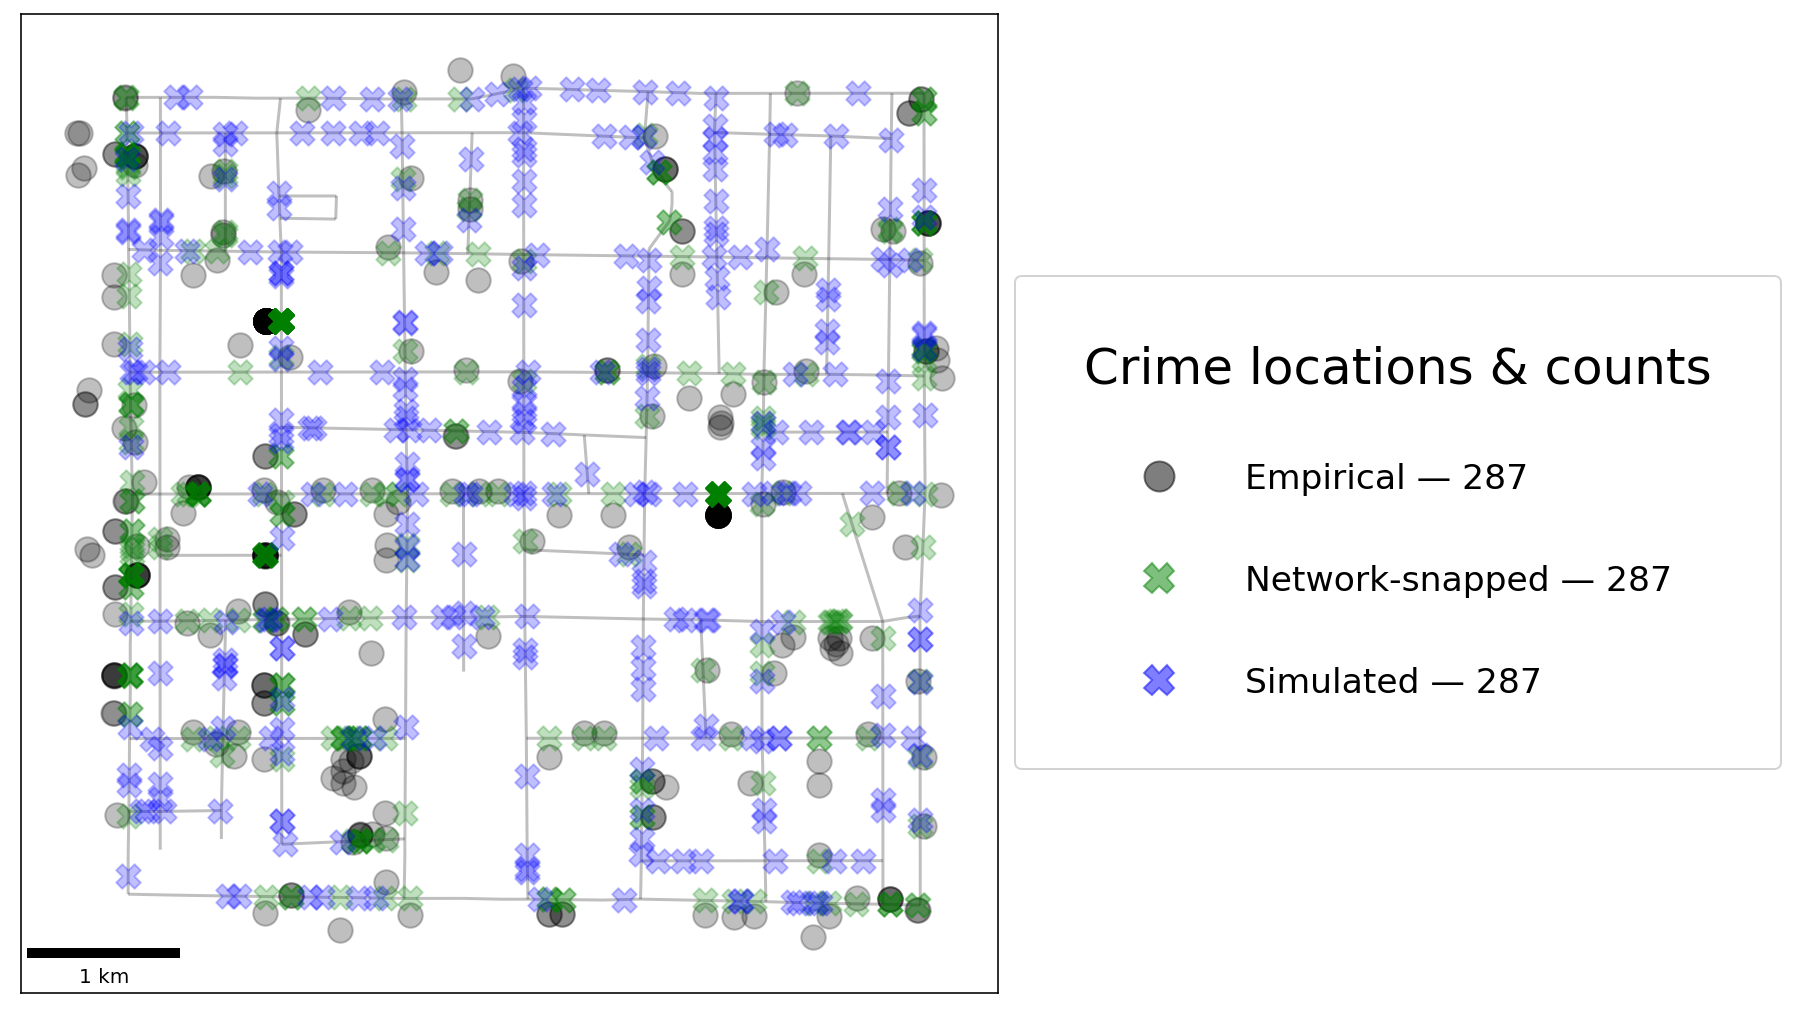

In [109]:
plotter()

------------------